In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
baseline_vars_df = pd.read_csv('baseline_data.csv')

In [5]:
baseline_vars_df

,year,qtr,state_fips,low,high,FIPS,State,YearQuarter,profitability,asset_quality
0,1999,1,1,0.40,1.11,1,alabama,1999Q1,0.001911,0.003194
1,1999,2,1,1.11,1.24,1,alabama,1999Q2,0.001911,0.003194
2,1999,3,1,0.40,1.11,1,alabama,1999Q3,0.001911,0.003194
3,1999,4,1,0.40,1.11,1,alabama,1999Q4,0.001911,0.003194
4,2000,1,1,1.11,1.24,1,alabama,2000Q1,0.005936,0.003637
...,...,...,...,...,...,...,...,...,...,...
1895,2007,2,56,1.32,1.40,56,wyoming,2007Q2,0.008248,0.000955
1896,2007,3,56,1.32,1.40,56,wyoming,2007Q3,0.008248,0.000955
1897,2007,4,56,1.32,1.40,56,wyoming,2007Q4,0.008248,0.000955
1898,2008,1,56,1.32,1.40,56,wyoming,2008Q1,0.006264,0.003617


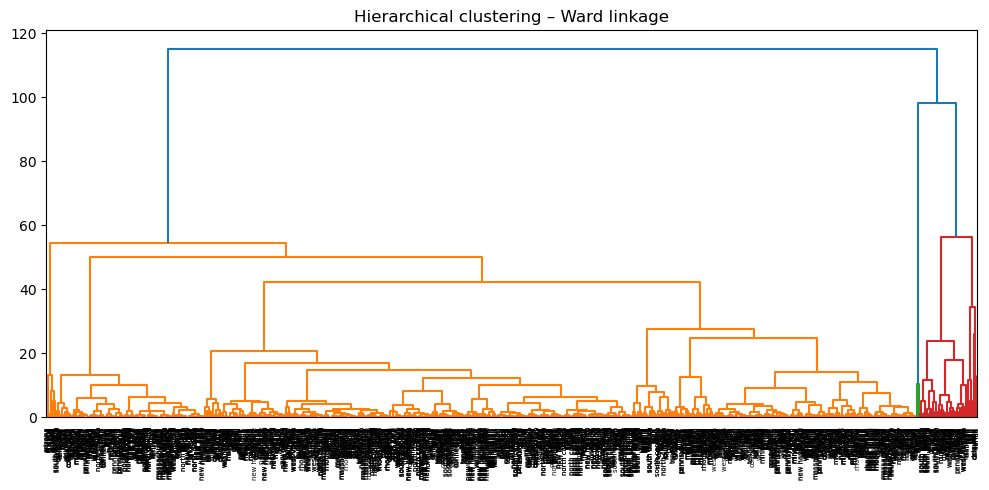

In [8]:
vars_X  = ["asset_quality", "profitability", "low"]
X_raw   = baseline_vars_df[vars_X].to_numpy(float)
states  = baseline_vars_df["State"].values

Xs = RobustScaler().fit_transform(X_raw)          # standardise

# ---------------------------------------------------------------
# 2)  Build dendrogram (optional visual)
# ---------------------------------------------------------------
Z = linkage(Xs, method="ward", metric="euclidean")

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=states, leaf_rotation=90)
plt.title("Hierarchical clustering – Ward linkage")
plt.tight_layout(); plt.show()



In [9]:
cluster_labels = fcluster(Z, t=2, criterion="maxclust")   # always 2 groups

# Largest cluster → G=0, smaller → G=1
lab_counts = pd.Series(cluster_labels).value_counts()
major_lab  = lab_counts.index[0]          # label of the biggest group
G          = np.where(cluster_labels == major_lab, 0, 1)

centroids = {g: Xs[G==g].mean(axis=0) for g in [0, 1]}
dist      = np.linalg.norm(Xs - np.vstack([centroids[g] for g in G]), axis=1)
score_hclust = -dist                     # higher (closer) → more typical

hclust_df = (
    pd.DataFrame({"State": states,
                  "G_hcluster": G,
                  "hclust_score": score_hclust})
      .sort_values("hclust_score", ascending=False)
      .reset_index(drop=True)
)

print("\nHierarchical‑clustering baseline groups (top 10 by score):")
print(hclust_df.head(10))


Hierarchical‑clustering baseline groups (top 10 by score):
       State  G_hcluster  hclust_score
0   missouri           0     -0.044615
1   missouri           0     -0.044615
2   missouri           0     -0.044615
3     alaska           0     -0.101782
4  minnesota           0     -0.144637
5  minnesota           0     -0.144637
6   kentucky           0     -0.180241
7   kentucky           0     -0.180241
8   kentucky           0     -0.180241
9   missouri           0     -0.202453


In [13]:
hclust_df.to_csv('hclust_df.csv', index=False)

States per baseline group
G_hcluster
0    47
1     3
Name: count, dtype: int64 



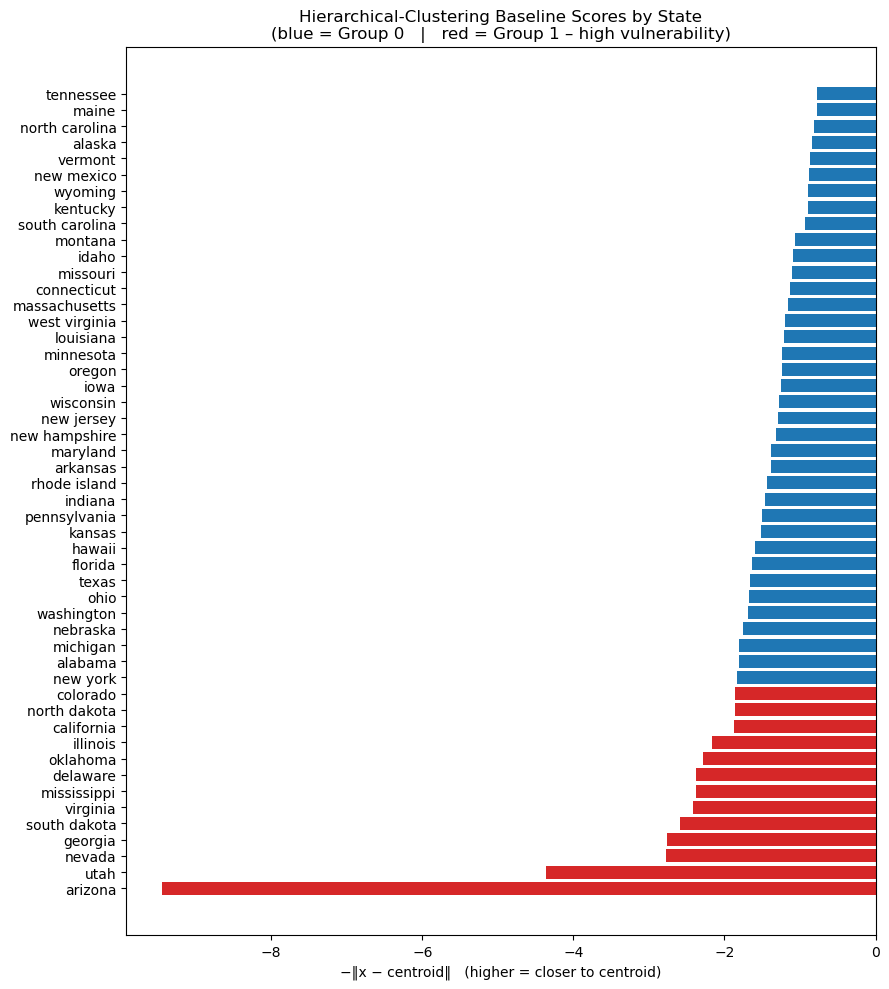

In [11]:
import pandas as pd, matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1)  Collapse duplicates   → one score & one G per state
# ---------------------------------------------------------------
state_summary = (
    hclust_df                         # from your clustering step
      .groupby("State", as_index=False)
      .agg(G_hcluster   = ("G_hcluster",   "first"),     # all rows share same label
           hclust_score = ("hclust_score", "mean"))      # average duplicates
      .sort_values("hclust_score", ascending=False)
      .reset_index(drop=True)
)

# ---------------------------------------------------------------
# 2)  Basic counts
# ---------------------------------------------------------------
print("States per baseline group")
print(state_summary["G_hcluster"].value_counts(), "\n")

# ---------------------------------------------------------------
# 3)  Horizontal bar plot  (blue = G0, red = G1)
# ---------------------------------------------------------------
color_map = {0: "#1f77b4", 1: "#d62728"}      # blue / red
# colour by score quartile instead of G label
colors = state_summary["hclust_score"].apply(
            lambda s: "#d62728" if s < state_summary["hclust_score"].quantile(0.25)
                      else "#1f77b4")


plt.figure(figsize=(9, 10))
plt.barh(state_summary["State"], state_summary["hclust_score"], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("−‖x − centroid‖   (higher = closer to centroid)")
plt.title("Hierarchical‑Clustering Baseline Scores by State\n"
          "(blue = Group 0   |   red = Group 1 – high vulnerability)")
plt.tight_layout()
plt.show()

## Gaussian Mixture Model

In [14]:
from sklearn.mixture import GaussianMixture

In [15]:
vars_X     = ["asset_quality", "profitability", "low"]
states     = baseline_vars_df["State"].values
X_raw      = baseline_vars_df[vars_X].values           # n × p

# standardise (important for GMM)
X_scaled   = RobustScaler().fit_transform(X_raw)

# ----------------------------------------------------------------
# 2)  Fit Gaussian‑Mixture  (choose k components; here k = 2)
# ----------------------------------------------------------------
gmm = GaussianMixture(
        n_components=2,         # feel free to raise / tune with BIC
        covariance_type="full",
        n_init=10,
        random_state=42
      ).fit(X_scaled)

# ----------------------------------------------------------------
# 3)  Observation‑level “G‑score”  =  log p(x)
# ----------------------------------------------------------------
logp = gmm.score_samples(X_scaled)          # length n

gmm_scores_df = pd.DataFrame({
    "State"   : states,
    "GMM_logp": logp                       # higher ⇒ more typical point
})

# ----------------------------------------------------------------
# 4)  OPTIONAL: collapse to one score per state (mean log‑p)
# ----------------------------------------------------------------
gmm_state_score = (
    gmm_scores_df.groupby("State")["GMM_logp"]
                 .mean()
                 .reset_index()
                 .sort_values("GMM_logp", ascending=False)
)

print("Observation‑level scores (first 5 rows):")
print(gmm_scores_df.head())

print("\nState‑level average scores (top 10):")
print(gmm_state_score.head(10))

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

Observation‑level scores (first 5 rows):
     State  GMM_logp
0  alabama -5.823357
1  alabama -4.161123
2  alabama -5.823357
3  alabama -5.823357
4  alabama -3.198277

State‑level average scores (top 10):
             State  GMM_logp
32  north carolina -2.546538
30      new mexico -2.595428
18           maine -2.597375
16        kentucky -2.688239
44         vermont -2.726231
49         wyoming -2.739848
1           alaska -2.752113
41       tennessee -2.772294
11           idaho -2.865828
39  south carolina -2.897751


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [16]:
gmm_scores_df.to_csv('gmm_scores_df.csv', index=False)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

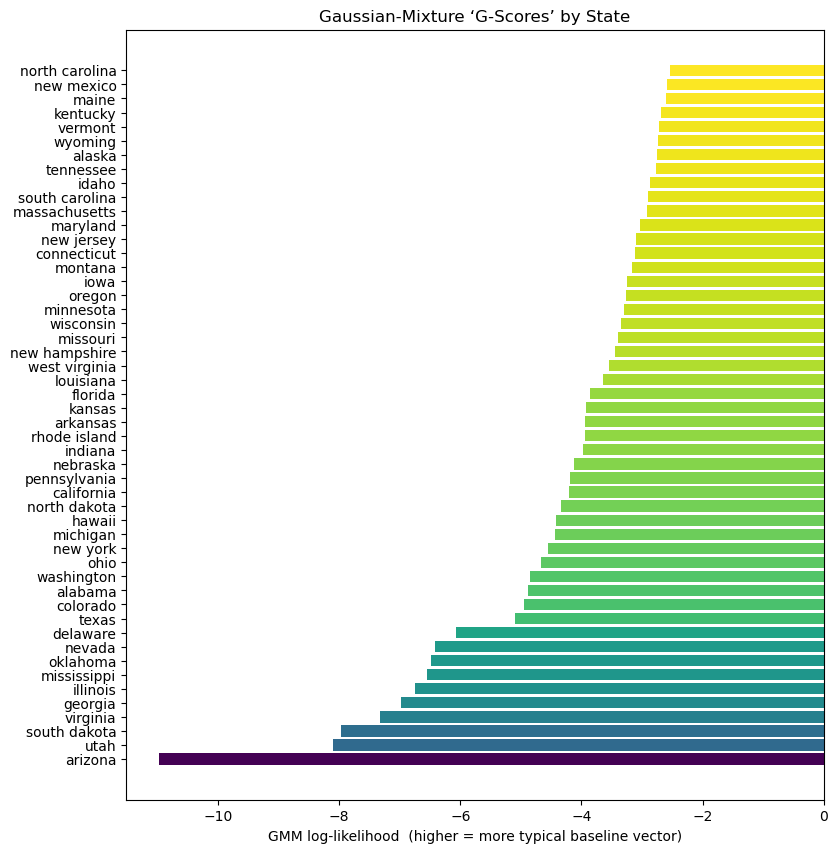

In [17]:
gmm_state_score_sorted = gmm_state_score.sort_values("GMM_logp", ascending=False)

# --- 1) Horizontal bar‑chart of state‑level log‑densities ----------
plt.figure(figsize=(9, 10))

# Colour‑map: darker ≈ higher density
norm   = plt.Normalize(gmm_state_score_sorted["GMM_logp"].min(),
                       gmm_state_score_sorted["GMM_logp"].max())
colors = plt.cm.viridis(norm(gmm_state_score_sorted["GMM_logp"].values))

plt.barh(gmm_state_score_sorted["State"],
         gmm_state_score_sorted["GMM_logp"],
         color=colors)

plt.gca().invert_yaxis()
plt.xlabel("GMM log‑likelihood  (higher = more typical baseline vector)")
plt.title("Gaussian‑Mixture ‘G‑Scores’ by State")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Log‑likelihood")
plt.tight_layout()
plt.show()

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


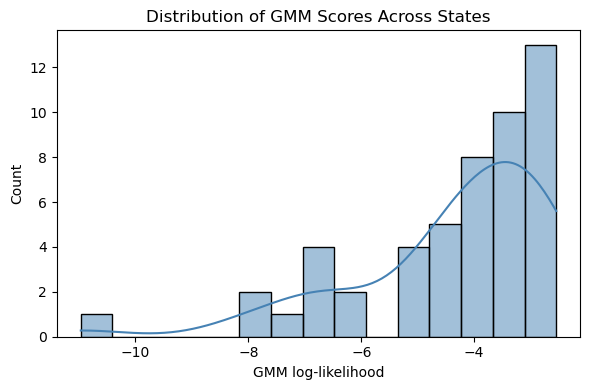

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(gmm_state_score["GMM_logp"], bins=15, kde=True, color="steelblue")
plt.xlabel("GMM log‑likelihood")
plt.title("Distribution of GMM Scores Across States")
plt.tight_layout()
plt.show()

In [19]:
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

NameError: name 'cov' is not defined

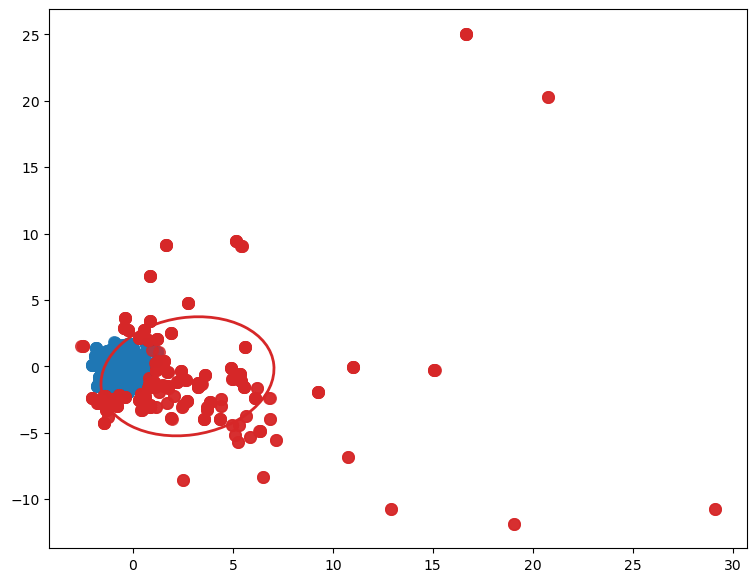

In [ ]:
X_std  = X_scaled                                # scaled predictors
states = baseline_vars_df["State"].values        # state labels
labels = gmm.predict(X_std)                      # component (0 / 1)

# ------------------------------------------------------------
# 2)  2‑D PCA for plotting
# ------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_std)

# ------------------------------------------------------------
# 3)  Helper: draw one‑sigma ellipse for each component
# ------------------------------------------------------------
def plot_cov_ellipse(ax, mean2d, cov2d, color, label=None, n_std=1.0):
    """Draw an n‑σ covariance ellipse (2‑D)."""
    eigvals, eigvecs = np.linalg.eigh(cov2d)
    order            = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    width, height = 2 * n_std * np.sqrt(eigvals)          # ellipse radii
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    ell = Ellipse(
        xy=mean2d,              # centre
        width=width,
        height=height,
        angle=angle,
        edgecolor=color,
        facecolor="none",
        lw=2,
        label=label
    )
    ax.add_patch(ell)
    """Draw ellipse of covariance matrix (2‑D)."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    width, height = 2 * n_std * np.sqrt(eigvals)  # 2*σ radii
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color,
                      facecolor="none", lw=2, label=label)
    ax.add_patch(ellipse)

# ------------------------------------------------------------
# 4)  Plot
# ------------------------------------------------------------
plt.figure(figsize=(9, 7))
palette = {0: "#1f77b4", 1: "#d62728"}   # blue vs red

# Scatter each state
for comp in np.unique(labels):
    idx = labels == comp
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1],
                s=70, alpha=0.8, c=palette[comp], label=f"Component {comp}")

# Optionally annotate a few extremes (top‑left corner)
# for i in range(len(states)):
#     if abs(X_2d[i, 0]) > 2 or abs(X_2d[i, 1]) > 2:
#         plt.text(X_2d[i, 0], X_2d[i, 1], states[i], fontsize=8)

# Draw 1‑σ ellipses of each Gaussian in the projected PCA space
for k in range(gmm.n_components):
    # transform the 3‑D covariance to 2‑D PCA space:
    cov_k_full = gmm.covariances_[k]            # 3×3
cov_k_2d   = pca.components_ @ cov_k_full @ pca.components_.T
mean_k_2d  = pca.transform(gmm.means_[k].reshape(1, -1))[0]

plot_cov_ellipse(plt.gca(), mean_k_2d, cov_k_2d,
                 color=palette[k], label=f"1σ ellipse {k}")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Gaussian‑Mixture Components in Baseline‑Variable Space")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest

Isolation‑Forest scores (top 10 most anomalous states):
      State  iso_score  normal_score
0   arizona   0.285948     -0.285948
1   arizona   0.285948     -0.285948
2   arizona   0.257239     -0.257239
3   arizona   0.257239     -0.257239
4   arizona   0.257239     -0.257239
5   arizona   0.257239     -0.257239
6   florida   0.232443     -0.232443
7   florida   0.232443     -0.232443
8  delaware   0.230681     -0.230681
9      utah   0.226524     -0.226524


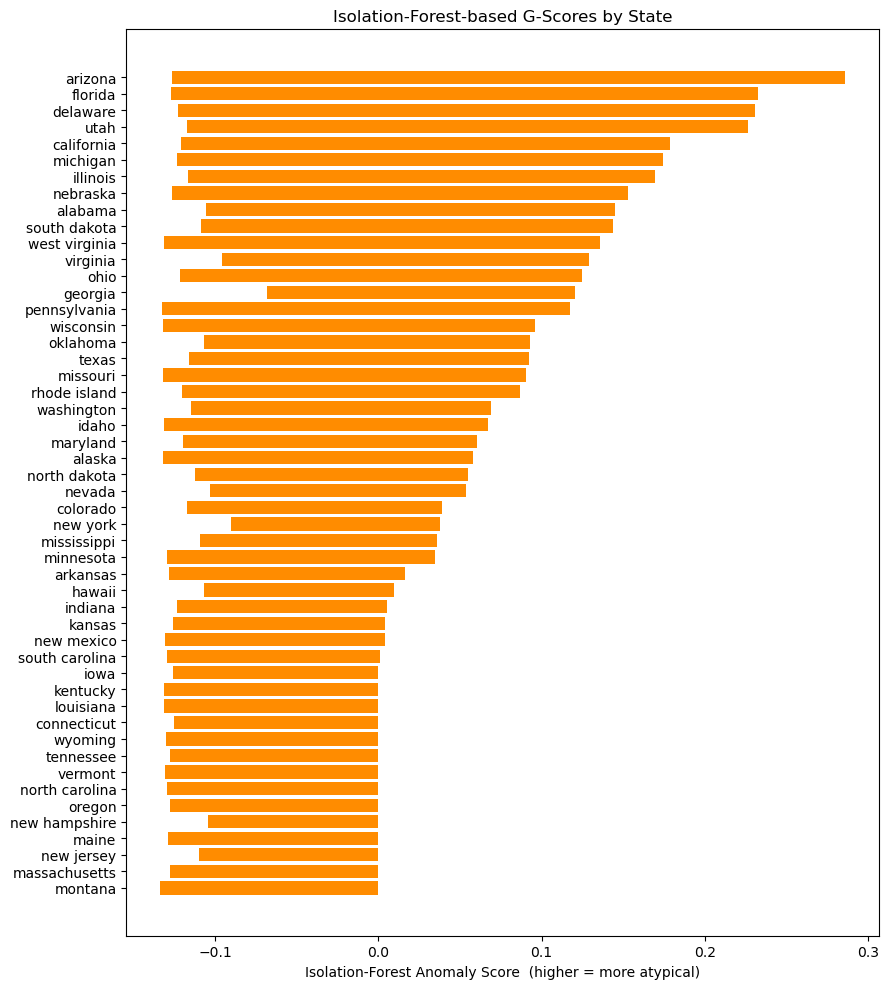

In [24]:
vars_X = ["asset_quality", "profitability", "low"]
states = baseline_vars_df["State"].values
X_raw  = baseline_vars_df[vars_X].values    # n_states × n_features

# Robust‑scale to reduce influence of outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# ---------------------------------------------------------------
# 2)  Fit Isolation Forest
# ---------------------------------------------------------------
iso = IsolationForest(
    n_estimators=100,
    contamination='auto',    # let the model infer expected outlier fraction
    max_samples='auto',
    random_state=42
).fit(X_scaled)

# ---------------------------------------------------------------
# 3)  Compute anomaly scores
#    - decision_function: higher = more “normal”
#    - we invert so that higher = more “anomalous” (vulnerability)
# ---------------------------------------------------------------
normal_scores = iso.decision_function(X_scaled)   # shape (n_states,)
iso_scores = -normal_scores                       # invert

# Create DataFrame of raw and inverted scores
iso_df = pd.DataFrame({
    "State":       states,
    "iso_score":   iso_scores,
    "normal_score": normal_scores
}).sort_values("iso_score", ascending=False).reset_index(drop=True)

print("Isolation‑Forest scores (top 10 most anomalous states):")
print(iso_df.head(10))

# ---------------------------------------------------------------
# 4)  Visualise  – bar chart of iso_score by state
# ---------------------------------------------------------------
plt.figure(figsize=(9, 10))
plt.barh(iso_df["State"], iso_df["iso_score"], color="darkorange")
plt.gca().invert_yaxis()
plt.xlabel("Isolation‑Forest Anomaly Score  (higher = more atypical)")
plt.title("Isolation‑Forest‑based G‑Scores by State")
plt.tight_layout()
plt.show()